# Sheridan Kamal

## DATA 71200 - Project 3 (Due 5/13/2020, 11:59p)

### Project
For my project, I will be using time series data and unsupervised machine learning methods to predict recessions. In this portion of the project, I will be using the training set created in Project 1 to perform PCA for feature selection to determine if feature reduction will improve the scaled logistic regression score. I will also perform k-Means clustering, Agglomerate clustering, and DBSCAN clustering.

### Data
I will be using the CSV file named 'Project Dataset.csv' that I generated in the previous project. Since this file has all of the features I wish to use for my model and the prediction labels are already encoded there are no data issues to deal with. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

data = pd.read_csv('Project Dataset.csv', sep = ',', parse_dates = ['Date'], index_col = 'Date')
data.head()

,10yr Tbond,2yr Spread,Fedrate,% Change Payrolls,CPI,% Change 12M,Recession
Date,,,,,,,
1976-06-01,7.86,0.80,5.48,0.000807,56.7,0.091205,0.0
1976-07-01,7.83,0.98,5.31,0.002154,57.0,0.153168,0.0
1976-08-01,7.77,1.14,5.29,0.001974,57.3,0.169327,0.0
1976-09-01,7.59,1.17,5.25,0.002359,57.6,0.226975,0.0
1976-10-01,7.41,1.43,5.02,0.000238,57.9,0.144672,0.0


In [2]:
#70/30 sequential train-test split
from sklearn.model_selection import train_test_split

X = data.iloc[:, 0:-1]
y = data.loc[:, 'Recession']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, shuffle=False, random_state=1)

In [3]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_train_std = StandardScaler().fit_transform(X_train)
pca = PCA()
X_pca = pca.fit(X_train_std)

print(pca.components_)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))

[[ 0.53390271 -0.39982079  0.56499595  0.08136045 -0.47272945  0.07601417]
 [-0.16188185 -0.1026587  -0.11757324  0.69450982 -0.0071048   0.68340151]
 [ 0.15095036  0.54611338 -0.16550654  0.49996666 -0.47129064 -0.42367466]
 [ 0.25148337  0.58734151 -0.02657068 -0.44037214 -0.22566234  0.58841222]
 [ 0.54837491  0.27380125  0.23769917  0.25172467  0.70930799 -0.03652125]
 [-0.54954275  0.33380761  0.76312306  0.06145727  0.01789395 -0.01101174]]
[0.48504041 0.21032748 0.1533313  0.10992819 0.0369815  0.00439112]
[0.48504041 0.69536789 0.84869919 0.95862738 0.99560888 1.        ]


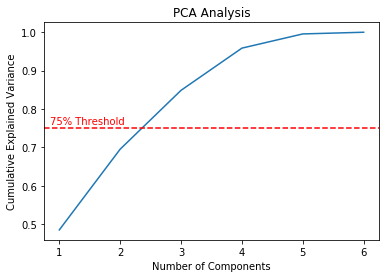

In [4]:
sns.lineplot(x = range(1, 7), y = np.cumsum(pca.explained_variance_ratio_))
plt.axhline(0.75, ls = '--', c = "red")
plt.text(x = 0.85, y = 0.76, s = '75% Threshold', c = "red")
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Analysis')
plt.show()

In [5]:
num_components = 3
pca = PCA(num_components)  
projected = pca.fit_transform(X_train_std)

result = pd.DataFrame(pca.components_, columns = X_train.columns, index = {'1', '2', '3'})
result

,10yr Tbond,2yr Spread,Fedrate,% Change Payrolls,CPI,% Change 12M
1,0.533903,-0.399821,0.564996,0.081360,-0.472729,0.076014
2,-0.161882,-0.102659,-0.117573,0.694510,-0.007105,0.683402
3,0.150950,0.546113,-0.165507,0.499967,-0.471291,-0.423675


In [6]:
n_pcs = pca.n_components_ 

most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = X_train.columns

most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

print(most_important_names)

['Fedrate', '% Change Payrolls', '2yr Spread']


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline

steps = [('scaler', StandardScaler()),
        ('LogReg', LogisticRegression())]

pipeline = Pipeline(steps)

pipeline.fit(X_train[['Fedrate', '% Change Payrolls', '2yr Spread']], y_train)

logpredict_scaled = pipeline.predict(X_test[['Fedrate', '% Change Payrolls', '2yr Spread']])

print("Feature Reduced and Scaled Logistic Regression Accuracy: {:.3f}".format(pipeline.score(X_test[['Fedrate', '% Change Payrolls', '2yr Spread']], y_test)))
print(classification_report(y_test, logpredict_scaled))
#No change from scaled logistic regression from project 2

Feature Reduced and Scaled Logistic Regression Accuracy: 0.937
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96       139
         1.0       0.85      0.58      0.69        19

    accuracy                           0.94       158
   macro avg       0.90      0.78      0.83       158
weighted avg       0.93      0.94      0.93       158



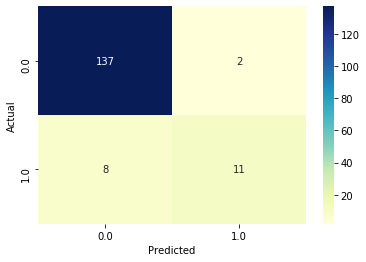

In [8]:
confusion_matrix = pd.crosstab(y_test, logpredict_scaled, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="YlGnBu")
#No change from scaled logistic regression from project 2

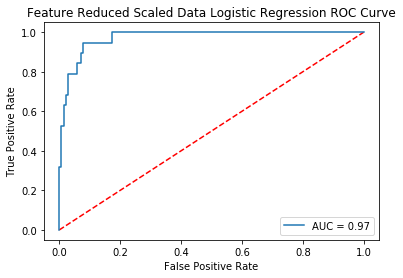

In [9]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

y_pred_prob_scaled = pipeline.predict_proba(X_test[['Fedrate', '% Change Payrolls', '2yr Spread']])[:,1]

logreg_scaled_roc_auc = roc_auc_score(y_test, y_pred_prob_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_scaled)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % logreg_scaled_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Feature Reduced Scaled Data Logistic Regression ROC Curve')
plt.legend(loc="lower right")
plt.show()
#AUC 0.01 less than scaled logistic regression from project 2

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans()
kmeans.fit(X_train_std)
labels = kmeans.predict(X_train_std)
centroids = kmeans.cluster_centers_

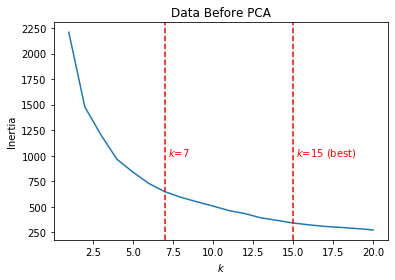

In [11]:
inertia = []

for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=1)
    kmeans.fit(X_train_std)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 21), inertia)
plt.axvline(7, ls = '--', c = "red")
plt.text(x = 7.2, y = 1000, s = '$k$=7', c = "red")
plt.axvline(15, ls = '--', c = "red")
plt.text(x = 15.2, y = 1000, s = '$k$=15 (best)', c = "red")
plt.title('Data Before PCA')
plt.xlabel('$k$')
plt.ylabel('Inertia')
plt.show()

In [12]:
from sklearn.metrics.cluster import adjusted_rand_score

adjusted_rand_score(y_train, kmeans.labels_)

0.026789799093998323

In [13]:
from sklearn.metrics import silhouette_score

silhouette_score(X_train_std, kmeans.labels_)

0.35254483589815266

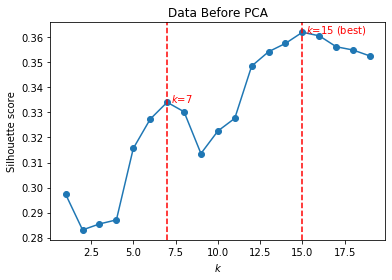

In [14]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=1).fit(X_train_std)
                for k in range(1, 21)]

inertias = [model.inertia_ for model in kmeans_per_k]

silhouette_scores = [silhouette_score(X_train_std, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.plot(range(1, 20), silhouette_scores, "o-")
plt.axvline(7, ls = '--', c = "red")
plt.text(x = 7.2, y = 0.334, s = '$k$=7', c = "red")
plt.axvline(15, ls = '--', c = "red")
plt.text(x = 15.2, y = 0.362, s = '$k$=15 (best)', c = "red")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.title('Data Before PCA')
plt.show()

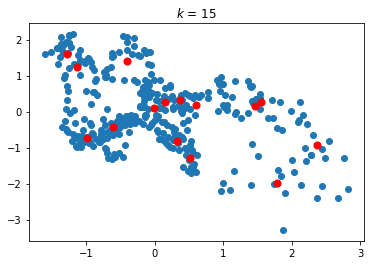

In [15]:
kmeans = KMeans(n_clusters=15, init='k-means++', max_iter=300, n_init=10, random_state=1)
pred_y = kmeans.fit_predict(X_train_std)
plt.scatter(X_train_std[:,0], X_train_std[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='red')
plt.title('$k$ = 15')
plt.show()

In [16]:
kmeans = KMeans()
kmeans.fit(projected)
labels = kmeans.predict(projected)
centroids = kmeans.cluster_centers_

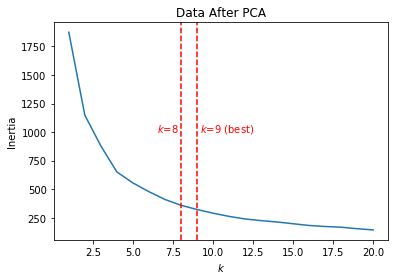

In [17]:
inertia = []

for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=1)
    kmeans.fit(projected)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 21), inertia)
plt.axvline(8, ls = '--', c = "red")
plt.text(x = 6.5, y = 1000, s = '$k$=8', c = "red")
plt.axvline(9, ls = '--', c = "red")
plt.text(x = 9.2, y = 1000, s = '$k$=9 (best)', c = "red")
plt.title('Data After PCA')
plt.xlabel('$k$')
plt.ylabel('Inertia')
plt.show()

In [18]:
adjusted_rand_score(y_train, kmeans.labels_)

0.029003019933130224

In [19]:
silhouette_score(projected, kmeans.labels_)

0.3720324853247664

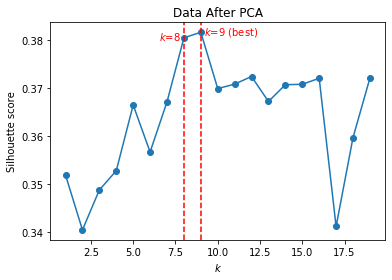

In [20]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=1).fit(projected)
                for k in range(1, 21)]

inertias = [model.inertia_ for model in kmeans_per_k]

silhouette_scores = [silhouette_score(projected, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.plot(range(1, 20), silhouette_scores, "o-")
plt.axvline(8, ls = '--', c = "red")
plt.text(x = 6.5, y = 0.38, s = '$k$=8', c = "red")
plt.axvline(9, ls = '--', c = "red")
plt.text(x = 9.2, y = 0.381, s = '$k$=9 (best)', c = "red")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.title('Data After PCA')
plt.show()

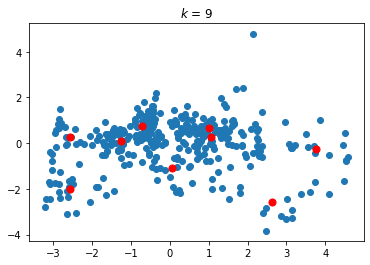

In [21]:
kmeans = KMeans(n_clusters=9, init='k-means++', max_iter=300, n_init=10, random_state=1)
pred_y = kmeans.fit_predict(projected)
plt.scatter(projected[:,0], projected[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='red')
plt.title('$k$ = 9')
plt.show()

Text(0.5, 1.0, 'Data Before PCA')

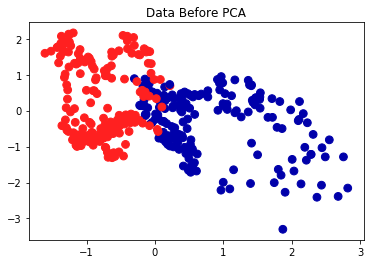

In [22]:
from sklearn.cluster import AgglomerativeClustering
import mglearn

agg = AgglomerativeClustering()
clusters = agg.fit_predict(X_train_std)

plt.scatter(X_train_std[:, 0], X_train_std[:, 1], c=clusters, cmap=mglearn.cm2, s=60)
plt.title('Data Before PCA')

In [23]:
adjusted_rand_score(y_train, clusters)

0.020297957786312153

In [24]:
silhouette_score(X_train_std, clusters)

0.2916650768460018

Text(0.5, 1.0, 'Data After PCA')

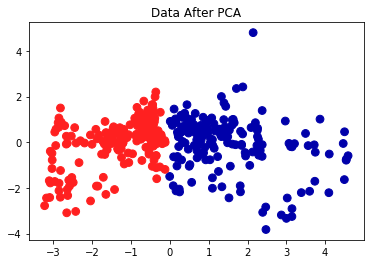

In [25]:
agg = AgglomerativeClustering()
clusters = agg.fit_predict(projected)

plt.scatter(projected[:, 0], projected[:, 1], c=clusters, cmap=mglearn.cm2, s=60)
plt.title('Data After PCA')

In [26]:
adjusted_rand_score(y_train, clusters)

0.019056233227528373

In [27]:
silhouette_score(projected, clusters)

0.3496586922332795

Text(0.5, 1.0, 'Data Before PCA')

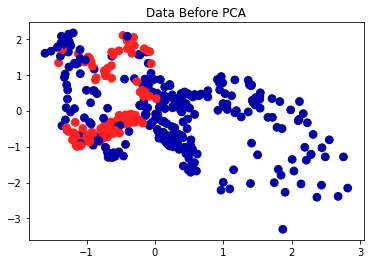

In [28]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN()
clusters = dbscan.fit_predict(X_train_std)

plt.scatter(X_train_std[:, 0], X_train_std[:, 1], c=clusters, cmap=mglearn.cm2, s=60)
plt.title('Data Before PCA')

In [29]:
adjusted_rand_score(y_train, clusters)

-0.12153941004134497

In [30]:
silhouette_score(X_train_std, clusters)

-0.13238700132453865

Text(0.5, 1.0, 'Data After PCA')

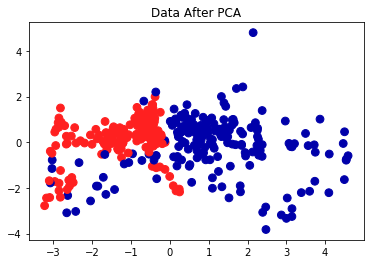

In [31]:
dbscan = DBSCAN()
clusters = dbscan.fit_predict(projected)

plt.scatter(projected[:, 0], projected[:, 1], c=clusters, cmap=mglearn.cm2, s=60)
plt.title('Data After PCA')

In [32]:
adjusted_rand_score(y_train, clusters)

0.050660323679760734

In [33]:
silhouette_score(projected, clusters)

0.11501776564688035

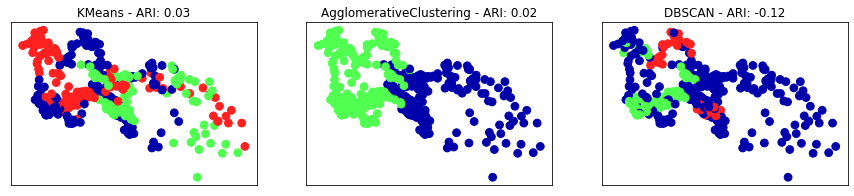

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3), subplot_kw={'xticks': (), 'yticks': ()})

algorithms = [KMeans(n_clusters=15), AgglomerativeClustering(), DBSCAN()]

for ax, algorithm in zip(axes[0:], algorithms):
    clusters = algorithm.fit_predict(X_train_std)
    ax.scatter(X_train_std[:, 0], X_train_std[:, 1], c=clusters, cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(y_train, clusters)))

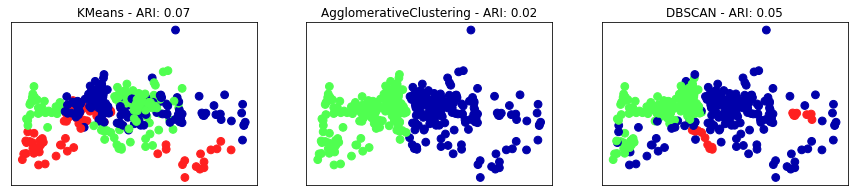

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3), subplot_kw={'xticks': (), 'yticks': ()})

algorithms = [KMeans(n_clusters=9), AgglomerativeClustering(), DBSCAN()]

for ax, algorithm in zip(axes[0:], algorithms):
    clusters = algorithm.fit_predict(projected)
    ax.scatter(projected[:, 0], projected[:, 1], c=clusters, cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(y_train, clusters)))

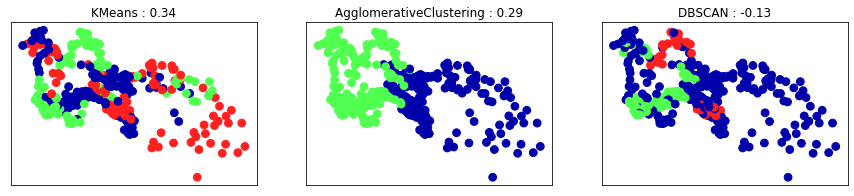

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3), subplot_kw={'xticks': (), 'yticks': ()})

algorithms = [KMeans(n_clusters=15), AgglomerativeClustering(), DBSCAN()]

for ax, algorithm in zip(axes[0:], algorithms):
    clusters = algorithm.fit_predict(X_train_std)
    ax.scatter(X_train_std[:, 0], X_train_std[:, 1], c=clusters, cmap=mglearn.cm3, s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__, silhouette_score(X_train_std, clusters)))

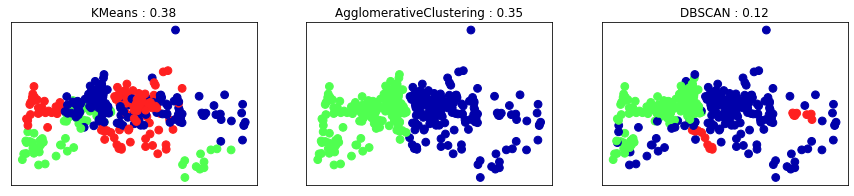

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3), subplot_kw={'xticks': (), 'yticks': ()})

algorithms = [KMeans(n_clusters=9), AgglomerativeClustering(), DBSCAN()]

for ax, algorithm in zip(axes[0:], algorithms):
    clusters = algorithm.fit_predict(projected)
    ax.scatter(projected[:, 0], projected[:, 1], c=clusters, cmap=mglearn.cm3, s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__, silhouette_score(projected, clusters)))